### REFERENCES:
  1. Creating more training data
    * (https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network)
  2. Preprocess, Feature Extract, Learn/Train, Classification (Pt. 3 - 6)
    * https://github.com/mesargent/freeway_guide_sign_detector/blob/master/contour_HOG_SVM_pipeline.ipynb

# Gate detection pipeline

  1. crop
  2. duplicate
    * reshape
    * blur?
    * transform (between -10 and 10 pixels) [1]
    * rotate [1]
    * flipping [1]
  3. preprocess [2]
    * filter out blue
      * max 255 - 50 for red and yellow
      * filter out blue - leave some no more than 100 test
    * apply threshold
    * find contours
    * calculate/find gate/bars (the more the better)
  4. feature extraction [2]
    * get features from HOG
  5. learn [2]
    * train SVM with HOG features 
  6. classification [2]
    * feed boxed images to trained SVM
    * use non gate images to test classifier

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import os
from matplotlib import pyplot as plt
%matplotlib inline

### 1. Crop images

In [2]:
## work-in-prograss

### 2. Duplicate

In [3]:
# transform, etc..

### 3. Preprocess

*useful functions*

In [4]:

def resize(img, scale): # resize image to scale value param
    return cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale) ) )


def scaled(img, scale): # returns new scale value
    img_shape_x, img_shape_y, channels = img.shape
    if img_shape_x > scale:
        return scale / img_shape_x
    else:
        return 1
    

def preprocess(image, lower_upper_list): # 2nd param now takes a list to handle python3
    lower = np.array(lower_upper_list[0], dtype="uint8")
    upper = np.array(lower_upper_list[1], dtype="uint8")
    
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask


*sample images/video path*

In [5]:
img2_path = "../tmp_files/gate1521499984175.jpg" # had to get a little creative to find this
img1_path = "../tmp_files/gate1521499942735.jpg" # gate detection was easier - all 3 bars
#vid1_path = "../img-to-video/run3.avi"
#vid2_path = "../img-to-video/run4.avi"

*import images*

In [6]:
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
#print("image 1 shape:", img1.shape )
#print("image 2 shape:", img2.shape )


*show both images*

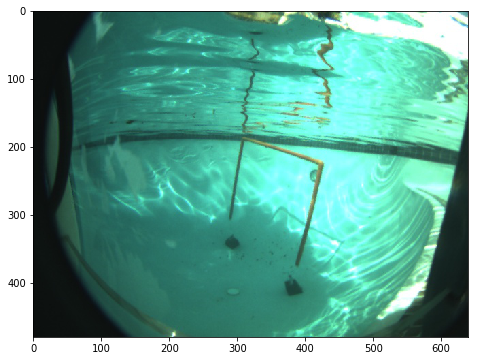

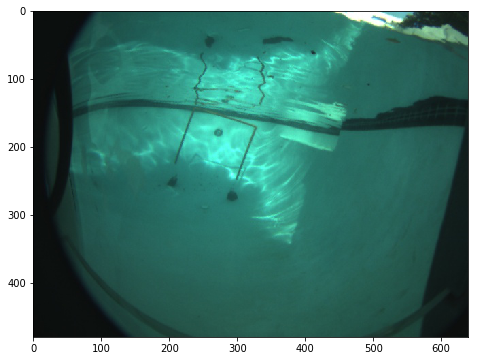

In [7]:
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) )
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) )
plt.show()

###  *filter out blues*

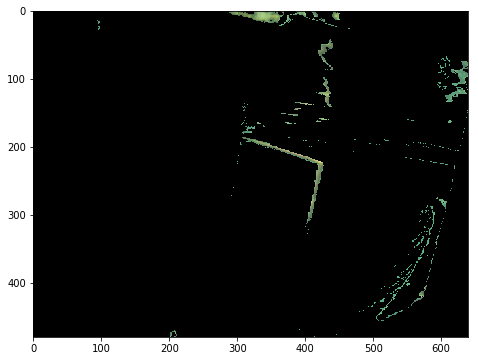

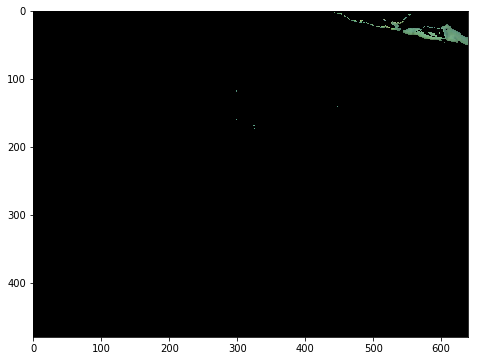

In [8]:
#lower_blue = np.array([0, 0, 0]) # good result values
#lower_blue = np.array([55, 55, 55]) # for testing
lower_blue = np.array([0, 180, 55]) # for testing # GOOD!

upper_blue = np.array([130, 255, 255]) # good result values
#upper_blue = np.array([150, 255, 255]) # for testing [r,g,r] - [135 - 150, 255, 255]
# upper_blue = np.array([150, 255, 255]) # for testing # GOOD!

#lower_blue = np.array([50, 100, 100]) # [0,180,80]
#upper_blue = np.array([150, 255, 255]) # [145,,]

lower_blue = np.array([50, 0, 80])
upper_blue = np.array([140, 255, 255])

pimage1, mask = preprocess(img1, [ lower_blue, upper_blue ])
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(pimage1, cv2.COLOR_BGR2RGB) )
plt.show()

pimage2, mask = preprocess(img2, [ lower_blue, upper_blue ])
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(pimage2, cv2.COLOR_BGR2RGB) )
plt.show()

*to grayscale*

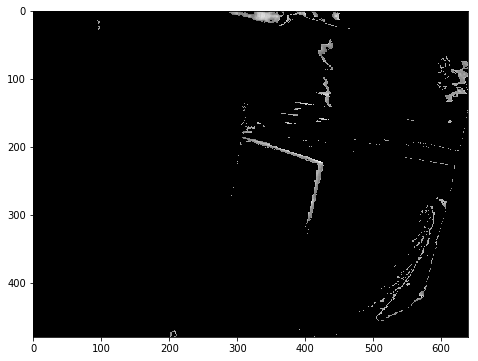

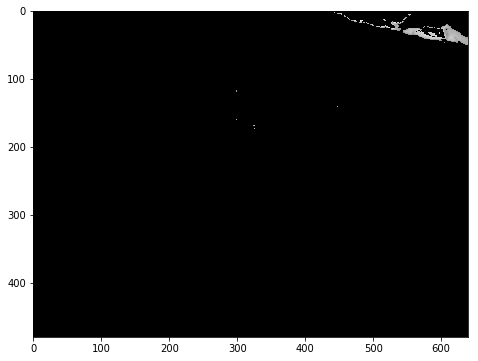

In [9]:
img1_gray = cv2.cvtColor(pimage1, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 6) )
plt.imshow(img1_gray, cmap='gray')
plt.show()

img2_gray = cv2.cvtColor(pimage2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 6) )
plt.imshow(img2_gray, cmap='gray')
plt.show()

### *apply threshold*

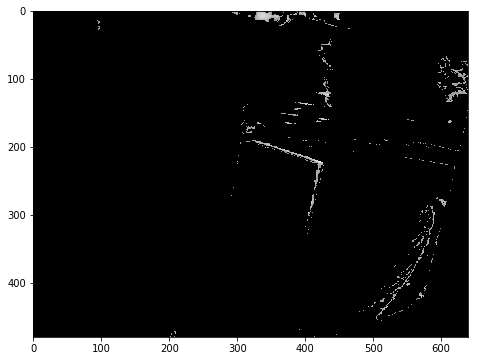

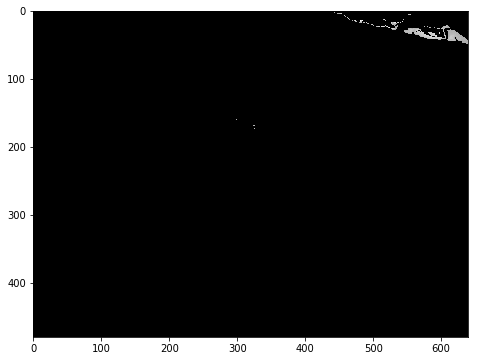

In [10]:
#ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, 0 )
ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, cv2.THRESH_TOZERO )

#ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, 0 )
ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, cv2.THRESH_TOZERO )

plt.figure(figsize=(10, 6) )
plt.imshow(img1_thresh, cmap='gray')
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(img2_thresh, cmap='gray')
plt.show()

### *find contours*

In [11]:

img1_c, img1_contours, img1_heirarchy = cv2.findContours(img1_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img2_c, img2_contours, img2_heirarchy = cv2.findContours(img2_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

*filter contours*

In [12]:
# not used

print(len(img1_contours) )
print(len(img2_contours) )

def contours_filter(img_contours):
    new_contour_list = []
    for cont in img_contours:
        if len(cont) > 20 and len(cont) < 200:
            new_contour_list.append(cont)
    return np.array(new_contour_list)

filt_1 = contours_filter(img1_contours)
filt_2 = contours_filter(img2_contours)

print(len(filt_1))
print(len(filt_2))


406
41
17
4


*draw contours*

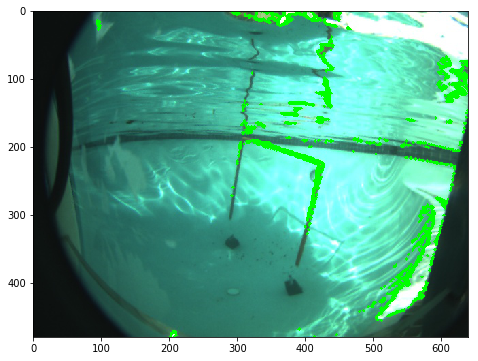

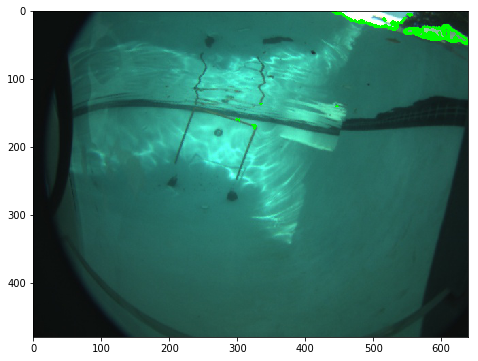

In [25]:
threshold_color = [0, 255, 0] # green

img1_copy = img1.copy()

cv2.drawContours(img1_copy, img1_contours, -1, threshold_color, 3)
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img1_copy, cv2.COLOR_BGR2RGB) )
plt.show()


img2_copy = img2.copy()

cv2.drawContours(img2_copy, img2_contours, -1, threshold_color, 3)
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img2_copy, cv2.COLOR_BGR2RGB) )
plt.show()

*useful bounding box functions*

In [29]:
def create_all_boxes(img_contours_list): # takes in a list of contour coordinates and returns an list of boxes around contours
    box_list = []
    for contour in img_contours_list:
        cv2.boundingRect(contour)
        box_list.append(contour)
    return box_list

def filter_boxes(img_rectangle_list, filter_size=0):
    filtered_boxes = []
    for rectangle in img_rectangle_list:
        if(rectangle[2] * rectangle[3] > filter_size):
            filtered_boxes.append(rectangle)
    return filtered_boxes

def draw_rectangles(img, img_rectangle_list, x_offset=0, y_offset=0):
    for x, y, w, h in img_rectangle_list:
        cv2.rectangle(
            img,
            (x - x_offset, y - y_offset),
            ( (x + x_offset) + w, (y + y_offset) + h),
            (0, 255, 0),
            2
        )

### *calculate/find gate/bars (the more the better)*

In [27]:
cpy1 = img1.copy()
rgb1 = rgb1 = cv2.cvtColor(cpy1, cv2.COLOR_BGR2RGB)

cpy2 = img2.copy()
rgb2 = rgb2 = cv2.cvtColor(cpy2, cv2.COLOR_BGR2RGB)

In [28]:
box_filter_size = 400

In [ ]:
''' ------------- img-1 ------------- '''
img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
#img1_all_boxes = create_all_boxes(img1_contours) # doesn't work... idk why
#print("Image 1 number of boxes:", len(img1_all_boxes) )

img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)
#print("Image 1 number of filtered boxes over size", box_filter_size, ":", len(img1_filter_boxes) )

print("(x-coord, y-coord, width, height) = ", img1_filter_boxes[0])


''' ------------- img-2 ------------- '''
img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
#img2_all_boxes = create_all_boxes(img2_contours) # doesn't work... idk why
#print("Image 2 number of boxes:", len(img2_all_boxes) )

img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)
#print("Image 2 number of filtered boxes over size", box_filter_size, ":", len(img2_filter_boxes) )


*draw boxes on images*

In [ ]:
## COMMENTED OUT FOR WORK IN PT. 4 - END BELOW

'''
draw_rectangles(rgb1, [img1_filter_boxes[1]], 5, 5)
draw_rectangles(rgb2, img2_filter_boxes, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()
'''
print()

In [ ]:
## Notes for 11/17/2017 meeting
# houghtransform
# Canny
# aspect ratio - divisible by eight
# test limit of svm - start small amount of images


### 4. Feature Extraction

*useful directory extraction/info methods*

In [13]:
# returns a list of file names in a directory: cwd is default
def get_dir_list(imgs_path):
    dir_list = []
    with os.scandir(imgs_path) as it: # from python3 docs
        for entry in it:
            if not entry.name.startswith(".") and entry.is_file:
                dir_list.append(imgs_path + entry.name)
    return dir_list

def get_img_data(imgs_path):
    img_list = []
    for img in imgs_path:
        img_list.append(cv2.imread(img) )
    return img_list

def get_features_with_label(image_data, hog, dimensions, label):
    data = []
    for img in image_data:
        image = cv2.resize(img, dimensions) # resize to proportion might help
        feats = hog.compute(image[:, :, 2])
        data.append((feats, label) )
    return data

In [14]:
def remove_blue(image):
    image[:,:,0] = 0
    return image

*get files from directory*

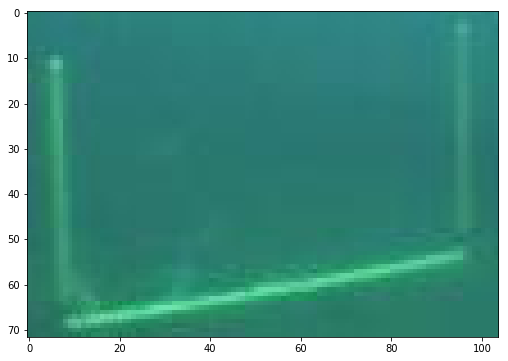

Shape:  (72, 104, 3)


In [15]:
pos_image_path = "positive/"
neg_image_path = "negative/"

pos_img_list = get_dir_list(pos_image_path)
neg_img_list = get_dir_list(neg_image_path)

positive_images = get_img_data(pos_img_list)
negative_images = get_img_data(neg_img_list)

plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(positive_images[0], cv2.COLOR_BGR2RGB) )
plt.show()

print("Shape: ", positive_images[0].shape)

Define HOG params/descriptor

In [16]:
min_dim = 80
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
bins = 9

dimensions = (min_dim, min_dim)

hog = cv2.HOGDescriptor(dimensions, block_size, block_stride, cell_size, bins)

Extract features and assign labels

In [17]:
p_images = get_features_with_label(positive_images, hog, dimensions, 1) # 1 is positive images
n_images = get_features_with_label(negative_images, hog, dimensions, 0) # 0 is negative images

In [18]:
print("Number of POSITIVE image features:", len(p_images) )
print("Number of NEGATIVE images features:", len(n_images) )

Number of POSITIVE image features: 59
Number of NEGATIVE images features: 142


## 5. Learn

*combine positive and negative features and shuffle*

In [19]:
imgs_df = p_images + n_images
np.random.shuffle(imgs_df) # shuffle
print("Total # of features:", len(imgs_df) )

Total # of features: 201


*split date in to testing/training sets*

In [20]:
feat, labels = map(list, zip(*imgs_df) )
feat_flat = [x.flatten() for x in feat]

X_df = pd.DataFrame(feat_flat) # convert to df
y_df = pd.Series(labels) # convert to series

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

print("Feature TRAINING data", X_train.shape)
print("Feature TESTING data ", X_test.shape)
print("Label TRAINING data  ", y_train.shape)
print("Label TESTING data   ", y_test.shape)


Feature TRAINING data (140, 2916)
Feature TESTING data  (61, 2916)
Label TRAINING data   (140,)
Label TESTING data    (61,)


MLP - activation="logistic" - sigmoid;
"adam" optimized gradient descent
alpha=how_sparse_
intercepts=weigths of bias

*train svm*

In [21]:
svm_l = SVC(C = 1.0, probability=True, random_state=2)
svm_l.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)

In [22]:
print(svm_l.score(X_train, y_train) )

0.6785714285714286


In [23]:
print("Test Accuracy:", svm_l.score(X_test, y_test) )
y_pred = svm_l.predict(X_test)
print("\nClassification report")
print(classification_report(y_test, y_pred) )

Test Accuracy: 0.7704918032786885

Classification report
             precision    recall  f1-score   support

          0       0.77      1.00      0.87        47
          1       0.00      0.00      0.00        14

avg / total       0.59      0.77      0.67        61



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
wrong = (y_pred != y_test).sum()
print("Misclassified samples:", wrong)

Misclassified samples: 14


In [25]:
confusion_matrix(y_pred, y_test)

# true []
# false []

array([[47, 14],
       [ 0,  0]])

### 6. Classification

*check features*

In [26]:
def get_positive_roi(img, roi_list, x_offset=0, y_offset=0):
    positive_roi = []
    for x, y, w, h in roi_list:
        roi = img[y:y + h, x:x + w, :3]
        roi_resized = cv2.resize(roi, dimensions) # dimensions defined as (80, 80) above
        features = hog.compute(roi_resized)
        proba = svm_l.predict_proba(features.reshape(1, -1) )[0] # will produce meaningless results on very small datasets per docs
        if proba[1] > .1:
            positive_roi.append((x, y, w, h) )
    return positive_roi

In [27]:
im1_cont_f = contours_filter(img1_contours)
im2_cont_f = contours_filter(img2_contours)

In [28]:
# Split all this below in to different cells for testing


img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
#img1_all_boxes = [cv2.boundingRect(c) for c in im1_cont_f]
img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)

roi_filtered_1 = get_positive_roi(rgb1, img1_filter_boxes)
draw_rectangles(rgb1, roi_filtered_1, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()


img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
#img2_all_boxes = [cv2.boundingRect(c) for c in im2_cont_f]
img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)

roi_filtered_2 = get_positive_roi(rgb2, img2_filter_boxes)
draw_rectangles(rgb2, roi_filtered_2, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()

print()

NameError: name 'filter_boxes' is not defined

# END

### TESTING

## Split method above into different cells for testing

*get boxes using preprocess*

In [77]:
# box_filter_size = 400 ABOVE
img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)

img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)


*info about PREPROCESS boxes*

In [78]:
print("PREPROCESS FILTERING:\n")
print("img1 ALL BOXES length:", len(img1_all_boxes) )
print("img1 FILTER BOXES length:", len(img1_filter_boxes) )
print()
print("img2 ALL BOXES length:", len(img2_all_boxes) )
print("img2 FILTER BOXES length:", len(img2_filter_boxes) )

PREPROCESS FILTERING:

img1 ALL BOXES length: 406
img1 FILTER BOXES length: 8

img2 ALL BOXES length: 41
img2 FILTER BOXES length: 2


*filter ROI using SVM*

In [79]:
roi_all_1 = get_positive_roi(rgb1, img1_all_boxes)
roi_filtered_1 = get_positive_roi(rgb1, img1_filter_boxes)

roi_all_2 = get_positive_roi(rgb2, img2_all_boxes)
roi_filtered_2 = get_positive_roi(rgb2, img2_filter_boxes)


*info about ROI boxes*

In [80]:
print("SVM FILTERING:\n")
print("img1 ALL BOXES length:", len(roi_all_1) )
print("img1 FILTER BOXES length:", len(roi_filtered_1) )
print()
print("img2 ALL BOXES length:", len(roi_all_2) )
print("img2 FILTER BOXES length:", len(roi_filtered_2) )

SVM FILTERING:

img1 ALL BOXES length: 270
img1 FILTER BOXES length: 4

img2 ALL BOXES length: 24
img2 FILTER BOXES length: 2


*comparison between PREPROCESS and ROI SVM boxes*

In [81]:
print("IMAGE 1 - Number of filtered boxes classified by SVM:  ", len(img1_filter_boxes) - len(roi_filtered_1) )
print("IMAGE 1 - On all boxes (no preprocess):                ", len(img1_all_boxes) - len(roi_all_1) )

print()

print("IMAGE 2 - Number of filtered boxes classified by SVM:  ", len(img2_filter_boxes) - len(roi_filtered_2) )
print("IMAGE 2 - On all boxes (no preprocess):                ", len(img2_all_boxes) - len(roi_all_2) )

IMAGE 1 - Number of filtered boxes classified by SVM:   4
IMAGE 1 - On all boxes (no preprocess):                 136

IMAGE 2 - Number of filtered boxes classified by SVM:   0
IMAGE 2 - On all boxes (no preprocess):                 17


In [82]:
def get_positive_roi(img, roi_list, x_offset=0, y_offset=0):
    print("FILTERED BOXES LIST LENGTH", len(roi_list) )
    positive_roi = []
    for x, y, w, h in roi_list:
        roi = img[y:y + h, x:x + w, :3]
        roi_resized = cv2.resize(roi, dimensions) # dimensions defined as (80, 80) above
        features = hog.compute(roi_resized)
        proba = svm.predict_proba(features.reshape(1, -1) )[0]
        print("\nproba:", svm.predict_proba(features.reshape(1, -1) ))
        print("proba[0]:", proba[0])
        print("proba[1]:", proba[1])
        print()
        if proba[1] > .1:
            positive_roi.append((x, y, w, h) )
            print("HIT!!!!!", "(", x, y, w, h, ")")
    print("\nPOSITIVE ROI LENGTH:", len(positive_roi) )
    return positive_roi

#AA_roi_filtered_2 = get_positive_roi(rgb2, img2_filter_boxes)

*draw rectangles on img*

In [83]:
draw_rectangles(rgb1, roi_filtered_1, 5, 5)
draw_rectangles(rgb2, roi_filtered_2, 5, 5)

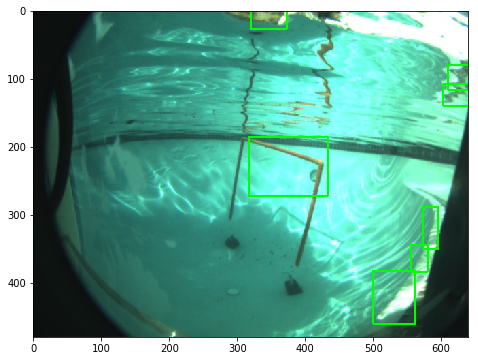

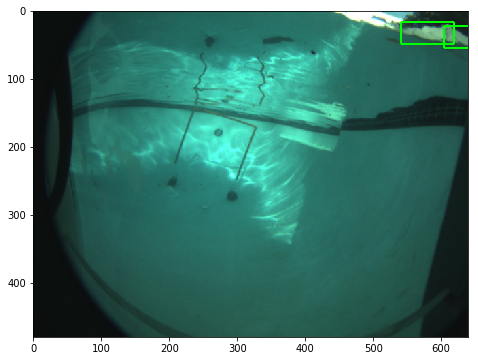

In [84]:
plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()